### Spring Loaded Inverted Pendulum

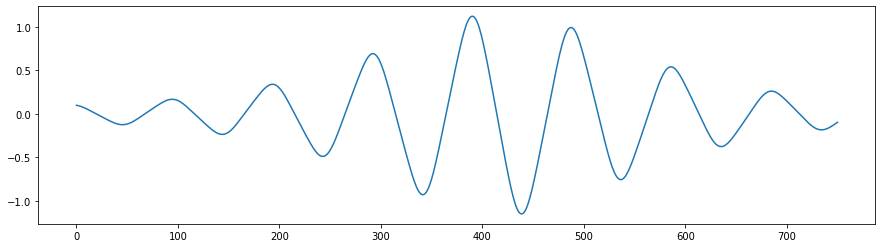

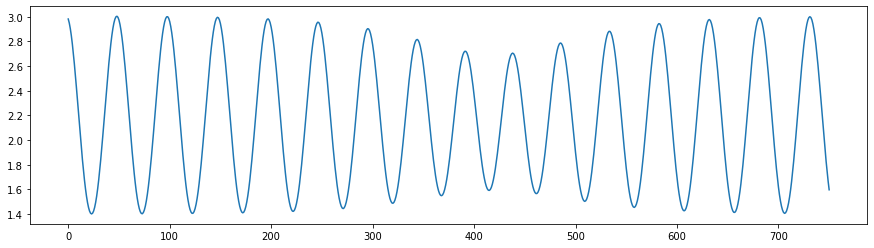

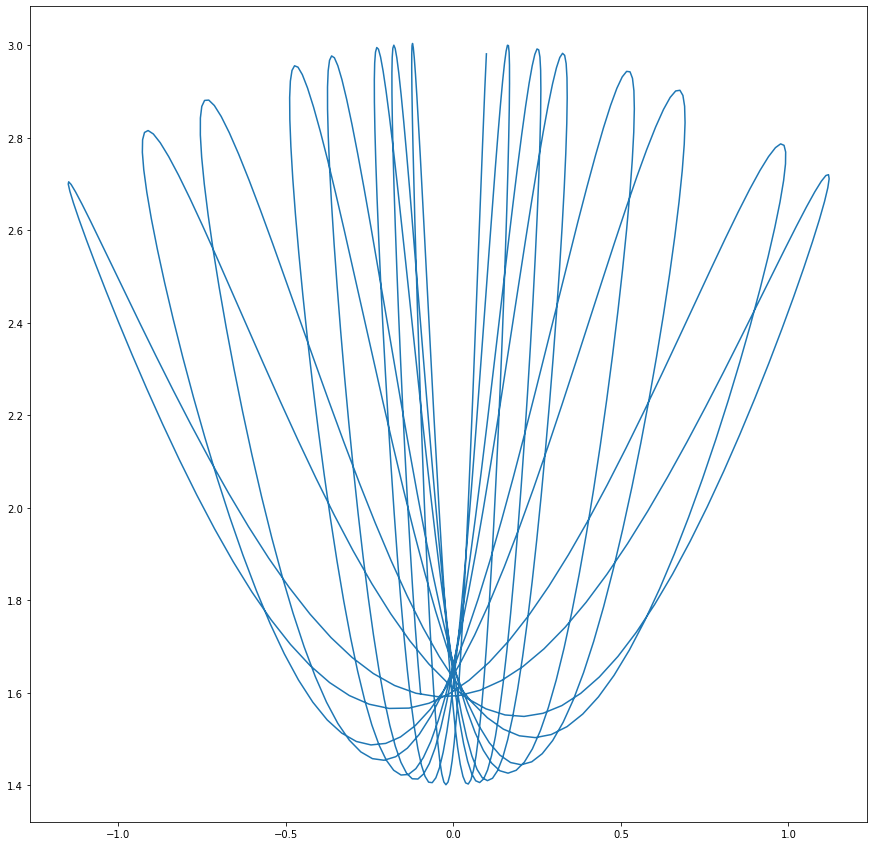

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import linalg
import copy
import math

class Leg:
    def __init__(self, l0, k, x0, in_contact = False):
        self.l0 = l0
        self.k = k
        self.x = x0
        self.in_contact = in_contact

class SLIP:
    def __init__(self, m = 1.0, g = 10.0,
                 x0 = 0.2, xd0 = -0.3, y0 = 1.2, yd0 = -0.1,
                 dt = 0.001, Q = np.eye(4), R = np.eye(1),
                 WIND_X = 700, scale = 100):
        self.m = m
        self.g = g
        
        self.x = np.array([[x0], [xd0], [y0], [yd0]])
        self.dt = dt
        
        self.Q = Q
        self.R = R
        
        self.WIND_X = WIND_X
        self.scale = scale
        self.target_x = 0.0
        
        self.legs = []
        
    def get_state(self):
        return self.x
    
    def add_leg(self, new_leg):
        self.legs.append(new_leg)
    
    def propagate_system(self, u):
        x  = self.x[0, 0]
        xd = self.x[1, 0]
        y  = self.x[2, 0]
        yd = self.x[3, 0]
        
        g = self.g
        m = self.m        
        
        xdd = 0
        ydd = 0
        
        # YOUR CODE BELOW
        
        
        
        # YOUR CODE ABOVE
        
        #print(ydd)
        
        self.x[1, 0] += xdd * self.dt
        self.x[0, 0] += self.x[1, 0] * self.dt
        
        self.x[3, 0] += ydd * self.dt
        self.x[2, 0] += self.x[3, 0] * self.dt
        
    def draw(self, cx, cy, scale = 100, color = (234, 123, 123), canvas = None):
        if (canvas is None):
            canvas = np.ones((700, 700, 3)) * 0
        
        h, w, _ = canvas.shape

        cv2.line(canvas, (0, h // 2), (w, h // 2), color, 2)
        
        cv2.circle(canvas, (int(cx + self.x[0, 0] * scale), int(cy - self.x[2, 0] * scale)), 17, color, 2)

        for leg in self.legs:
            leg_color = (23, 234, 21)
            
            if (leg.in_contact == False):
                leg_color = (123, 134, 21)
            
            cv2.line(canvas, (int(cx + self.x[0, 0] * scale), int(cy - self.x[2, 0] * scale)),
                             (int(cx + leg.x * scale), cy), leg_color, 2)

        return canvas
    
def state_action_cost(x, u, Q, R):
    cost = x.T @ Q @ x + u.T @ R @ u
    
    return cost

def episode_cost(x_hist, u_hist, Q, R):
    total_cost = 0
    cost_hist = []
    
    for x, u in zip(x_hist, u_hist):
        cost = state_action_cost(x, u, Q, R)
        
        total_cost += cost
        cost_hist.append(cost)
    
    return total_cost, cost_hist

def run_slip_episode(m = 1.0, g = 10.0,
                 x0 = 0.2, xd0 = -0.3, y0 = 1.2, yd0 = -0.1,
                 dt = 0.01, Q = np.eye(4), R = np.eye(1),
                 WIND_X = 700, scale = 100):
    WIND_X = 700
    WIND_Y = 700
    canvas = np.ones((700, 700, 3), np.uint8) * 70
    
    slip = SLIP(m, g, x0, xd0, y0, yd0,
                dt, Q, R, WIND_X, scale)

    l1 = Leg(5, 100, -1, True)
    l2 = Leg(5, 100, 1, True)
    
    slip.add_leg(l1)
    slip.add_leg(l2)
    
    iter_num = 750
    i = 0

    x_traj = []
    y_traj = []
    u_traj = []
    
    Q = np.eye(4) * 1
    
    #Q[:2, :2] *= 10
    
    R = np.eye(1)
    
    horizon = 10

    F_max = 20
    
    while(True):
        state = slip.get_state()

        control = np.array([[0]])
        
        slip.propagate_system(control)
        
        x_traj.append(state[0, 0])
        y_traj.append(state[2, 0])
        u_traj.append(control)
        
        canvas = cv2.addWeighted(canvas, 0.93, canvas, 0, 0)
        slip.draw(WIND_X // 2, WIND_Y // 2, canvas = canvas, scale = scale)

        cv2.imshow("slip", canvas)
        
        i += 1

        if (i > iter_num):
            break
        
        key = cv2.waitKey(10) & 0xFF
        
        if (key == ord('q')):
            break
    
    cv2.destroyAllWindows()
    cv2.waitKey(10)
    
    return x_traj, y_traj

Q = np.eye(4)
Q[0, 0] *= 10
#Q[1, 1] *= 0.1
R = np.eye(1) * 1

x_hist, y_hist = run_slip_episode(m = 1.0, g = 10,
                 x0 = 0.1, xd0 = -0.1, y0 = 3, yd0 = -0.5,
                 dt = 0.01, Q = np.eye(4), R = np.eye(1),
                 WIND_X = 700, scale = 50)

def plot_1d(data):
    plt.figure(figsize=(15, 4))
    plt.plot(data)
    plt.show()

plot_1d(x_hist)
plot_1d(y_hist)

plt.figure(figsize=(15, 15))
plt.plot(x_hist, y_hist)
plt.show()